# **Recommendation System**
Recommendation Systems are the systems that predict and filter the future preferences of user based based on their past experience. They are widely to recommend 
* similar products (Amazon, Flipkart)
* relevant media, e.g. photos, videos and stories (Instagram)
* relevant series and movies (Netflix, Amazon Prime Video, Hotstar)
* relevant songs and podcasts (Spotify)
* relevant videos (YouTube)
* similar users, posts (LinkedIn, Twitter, Instagram)
* relevant dishes and restaurants (Uber Eats, Zomato, Swiggy)

There are mainly 2 types of Recommendation System
1. Content Based RS
1. Collaborative Filtering
![](https://user-images.githubusercontent.com/43712046/69491476-766eb100-0e5b-11ea-8fa7-6bfc781045a8.png)

# **Content Based Recommendation Systems**
There are cases when the user is new on a platform and we end up having no prior information on the user. In such scenerios, we recommend similar items based on comments, feedbacks, reviews, description of the items with which the user interacts. 

Models/ Algorithms like TF-IDF score, word2vec are used to capture the similarty in Content Based RS.

In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from string import punctuation

import nltk as nltk
from nltk.tokenize import word_tokenize

import string

from tqdm import tqdm

import gensim.downloader as api

import gensim




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Loading the Dataset**

In [35]:
df_netflix = pd.read_csv("netflix_titles.csv")
print (df_netflix.shape)
df_netflix.head()

(7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


# ## **Analyses of TV Shows v/s Movies**

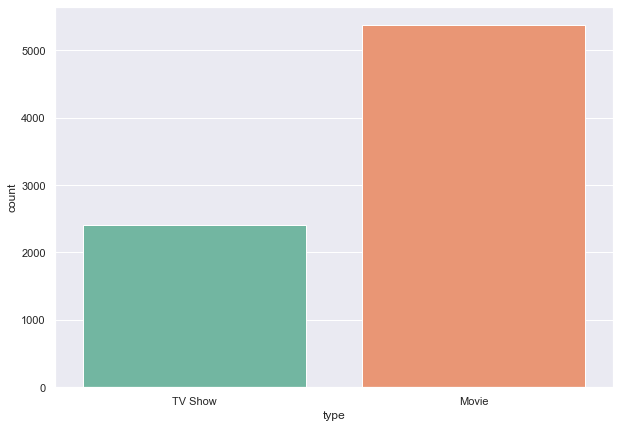

In [36]:
plt.figure(figsize=(10,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=df_netflix, palette="Set2")

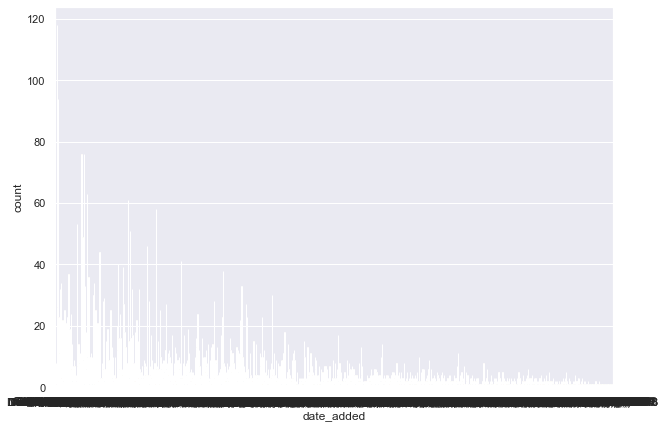

In [37]:
plt.figure(figsize=(10,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="date_added", data=df_netflix, palette="Set2")

## **County wise analysis**

In [38]:
import itertools
list_country = [x.split(', ') for x in df_netflix.dropna(subset=['country'])['country'].tolist()]
list_country = list(itertools.chain(*list_country))

from collections import Counter
df_netflix_country_count = pd.DataFrame(Counter(list_country).most_common()[:10], columns=['Country', 'Count'])

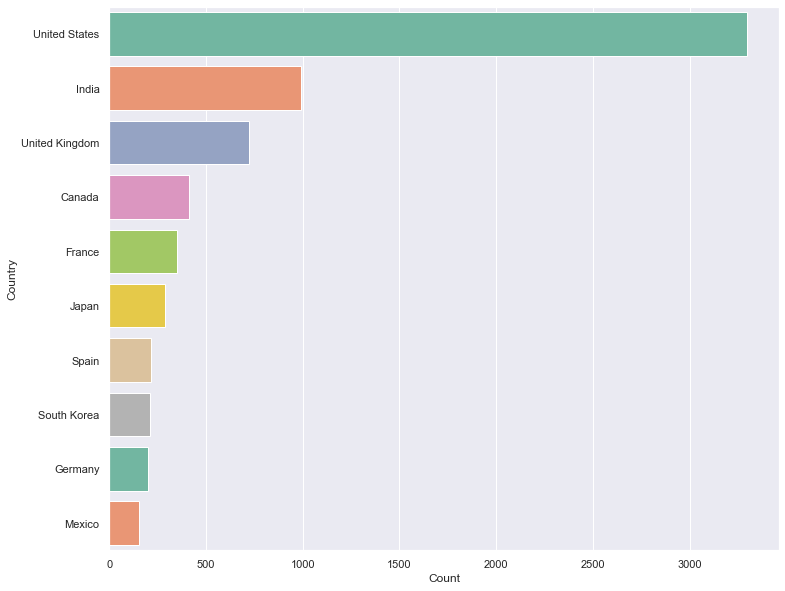

In [39]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.barplot(y="Country", x='Count', data=df_netflix_country_count, palette="Set2", orient='h')

## **Year wise analysis**

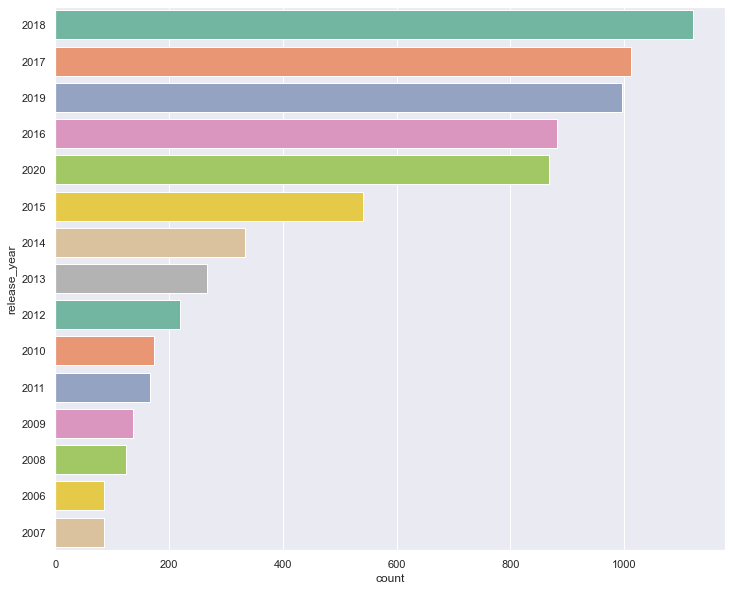

In [94]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y='release_year', data=df_netflix, palette="Set2", order=df_netflix['release_year'].value_counts().index[0:15])

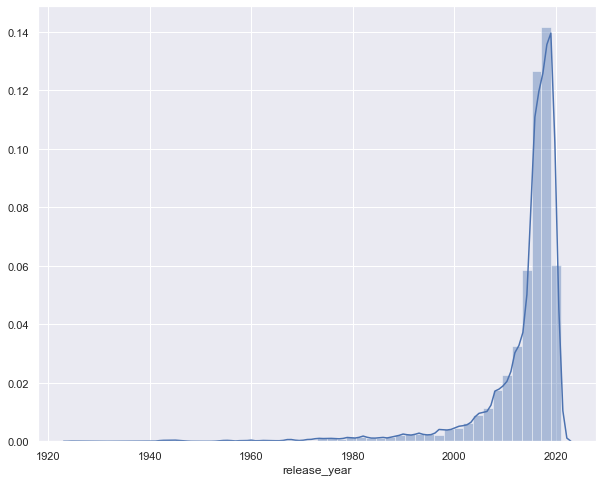

In [9]:
# most release happed in netflix over a time
plt.figure(figsize=(10,8))
sns.distplot(df_netflix['release_year']);

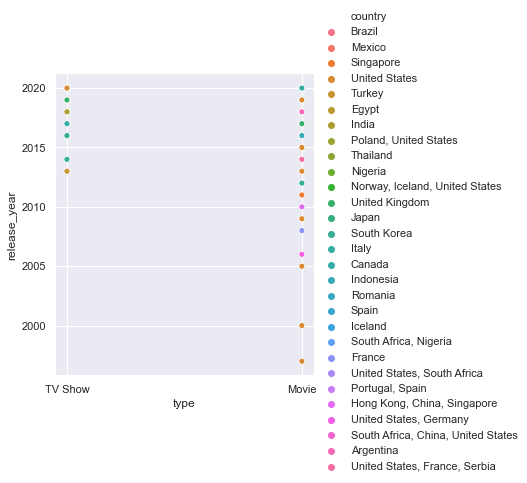

In [96]:
sns.relplot(x="type", y="release_year", hue="country",data=df_netflix[:100]);

## **Preprocessing of the data for RS**

### **Retaining only Relevant Columns**

In [30]:
df_netflix.drop(columns=['director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'type'], inplace=True)
df_netflix.head()

,show_id,title,listed_in,description
0,s1,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,7:19,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,23:59,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,9,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,21,Dramas,A brilliant group of students become card-coun...


### **Removing Punctuations and Stopwords**

In [41]:
import nltk as nltk
from nltk.tokenize import word_tokenize

df_netflix['title_list'] = df_netflix['title'].str.lower()
df_netflix['listed_in'] = df_netflix['listed_in'].str.lower()
df_netflix['description'] = df_netflix['description'].str.lower()

df_netflix['title_list'] = df_netflix['title_list'].apply(word_tokenize)
df_netflix['listed_in'] = df_netflix['listed_in'].apply(word_tokenize)
df_netflix['description'] = df_netflix['description'].apply(word_tokenize)

In [49]:
import nltk

In [50]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [42]:
from nltk.corpus import stopwords
from string import punctuation

list_stopwords = set(stopwords.words('english') + list(punctuation))
df_netflix['title_list'] = df_netflix['title_list'].apply(lambda x: [word for word in x if word not in list_stopwords])
df_netflix['listed_in'] = df_netflix['listed_in'].apply(lambda x: [word for word in x if word not in list_stopwords])
df_netflix['description'] = df_netflix['description'].apply(lambda x: [word for word in x if word not in list_stopwords])

In [43]:
import string

df_netflix['description'] = df_netflix['description'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
df_netflix['description'] = df_netflix['description'].apply(lambda x : [word for word in x if len(word) > 0])

In [44]:
df_netflix['title_list'] = df_netflix['title_list'].apply(lambda x : list(set(x)))
df_netflix['listed_in'] = df_netflix['listed_in'].apply(lambda x : list(set(x)))
df_netflix['description'] = df_netflix['description'].apply(lambda x : list(set(x)))

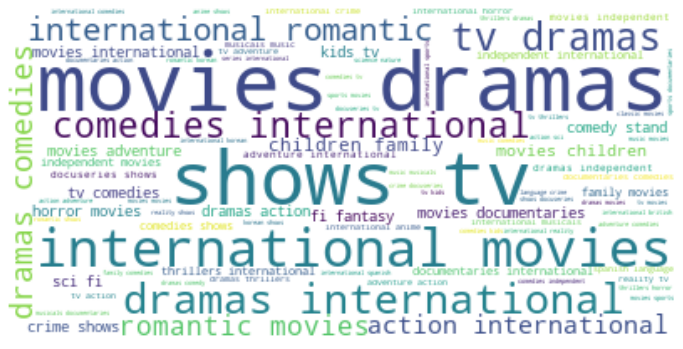

In [46]:
from wordcloud import WordCloud

list_genre = df_netflix['listed_in'].tolist()
list_genre = list(itertools.chain(*list_genre))
genre = ' '.join(list_genre)

plt.figure(figsize=(12,10))
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="white").generate(genre)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
## **WordCloud for Description**

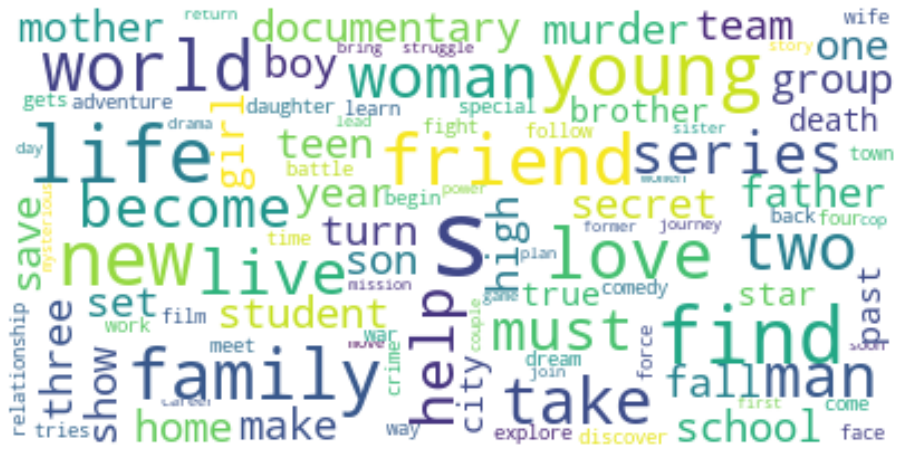

In [47]:
list_description = df_netflix['description'].tolist()
list_description = list(itertools.chain(*list_description))
description = ' '.join(list_description)

plt.figure(figsize=(16,12))
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="white").generate(description)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

C:\Users\sbandgar/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [49]:
!gunzip C:\Users\sbandgar/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz

'gunzip' is not recognized as an internal or external command,
operable program or batch file.


In [54]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [40]:
matrix_netflix_vocab = []
for list_ in df_netflix.to_numpy():
    list_[2] = [word for word in list_[2] if word in wv.vocab]
    list_[3] = [word for word in list_[3] if word in wv.vocab]
    list_[4] = [word for word in list_[4] if word in wv.vocab]
    matrix_netflix_vocab.append(list_)
df_netflix_vocab = pd.DataFrame(matrix_netflix_vocab, columns=df_netflix.columns)

In [41]:

def recommendation(title):
    matrix_netflix_title_vocab = []
    for list_ in df_netflix[df_netflix['title'] == title].to_numpy():
        list_[2] = [word for word in list_[2] if word in wv.vocab]
        list_[3] = [word for word in list_[3] if word in wv.vocab]
        list_[4] = [word for word in list_[4] if word in wv.vocab]
        matrix_netflix_title_vocab.append(list_)

    matrix_similarity = []
    pbar = tqdm(matrix_netflix_vocab)
    for list1 in pbar:
        for list2 in matrix_netflix_title_vocab:
            score_catg = wv.n_similarity(list1[2], list2[2])
            score_desc = wv.n_similarity(list1[3], list2[3])
            try:
                score_title = wv.n_similarity(list1[4], list2[4])/2
            except:
                score_title = 0
            if ((list1[1] != list2[1]) & (score_catg > 0.85)):
                matrix_similarity.append([list1[1], list2[1], score_title, score_catg, score_desc])
        pbar.update()
    pbar.close()
    df_netflix_similarity = pd.DataFrame(matrix_similarity, columns = ['recommendation','title','score_title', 'score_category', 'score_description'])
    df_netflix_similarity['final_score'] = df_netflix_similarity['score_title'] + df_netflix_similarity['score_category'] 
    + df_netflix_similarity['score_description']
    return (df_netflix_similarity.sort_values(by=['final_score', 'score_category', 'score_description', 'score_title'],
                                              ascending=False).head(10))

In [47]:
recommendation('Terminator Salvation')

100%|██████████| 7787/7787 [00:06<00:00, 1134.80it/s]


,recommendation,title,score_title,score_category,score_description,final_score
162,Terminator 3: Rise of the Machines,Terminator Salvation,0.283157,1.00000,0.540204,1.823361
124,Planet Hulk,Terminator Salvation,0.184595,1.00000,0.614776,1.799372
34,Chappie,Terminator Salvation,0.120098,1.00000,0.654727,1.774825
107,Marvel's Iron Man & Hulk: Heroes United,Terminator Salvation,0.171694,1.00000,0.602459,1.774153
21,Avengers: Infinity War,Terminator Salvation,0.214154,1.00000,0.555739,1.769893
32,Bright,Terminator Salvation,0.107475,1.00000,0.633160,1.740636
131,Resident Evil: Afterlife,Terminator Salvation,0.224173,0.88396,0.632140,1.740272
46,Doom: Annihilation,Terminator Salvation,0.223311,0.88396,0.611735,1.719005
48,Dragonheart 3: The Sorcerer,Terminator Salvation,0.172815,1.00000,0.534860,1.707675
159,Superman Returns,Terminator Salvation,0.176052,1.00000,0.504837,1.680889


In [126]:
recommendation('Black Panther')

100%|██████████| 7787/7787 [00:02<00:00, 3753.67it/s]


,recommendation,title,score_title,score_category,score_description,final_score
35,Clash of the Titans,Black Panther,0.047077,1.000000,0.674041,1.721117
67,Halo: The Fall of Reach,Black Panther,0.052581,1.000000,0.655358,1.707939
33,Chappie,Black Panther,0.112706,1.000000,0.579021,1.691727
79,Illang: The Wolf Brigade,Black Panther,0.219760,0.902778,0.566434,1.688972
107,Men in Black,Black Panther,0.297452,0.885755,0.503077,1.686284
38,DC's Legends of Tomorrow,Black Panther,0.086030,0.909350,0.689813,1.685193
158,Superman Returns,Black Panther,0.090467,1.000000,0.593951,1.684417
140,Season of the Witch,Black Panther,0.126985,1.000000,0.556901,1.683886
86,Jupiter Ascending,Black Panther,0.083517,1.000000,0.598604,1.682121
106,Marvel's Iron Man & Hulk: Heroes United,Black Panther,0.136722,1.000000,0.539501,1.676223


In [127]:
recommendation('Friends')

100%|██████████| 7787/7787 [00:01<00:00, 4008.13it/s]


,recommendation,title,score_title,score_category,score_description,final_score
29,Girlfriends,Friends,0.306857,0.853450,0.651396,1.811704
86,Toast of London,Friends,0.112076,0.924088,0.686581,1.722745
21,Episodes,Friends,0.040227,1.000000,0.644352,1.684579
18,Dad's Army,Friends,0.177361,0.924088,0.576079,1.677529
10,Big Mouth,Friends,0.085473,0.853450,0.722250,1.661173
61,Real Rob,Friends,0.090192,0.853450,0.693652,1.637294
38,I'm Sorry,Friends,0.123332,0.853450,0.657182,1.633965
23,F is for Family,Friends,0.199680,0.853450,0.572685,1.625816
74,The Andy Griffith Show,Friends,0.031710,1.000000,0.590680,1.622389
26,Frasier,Friends,0.000000,1.000000,0.619905,1.619905


In [128]:
recommendation('Transformers: Robots in Disguise')

100%|██████████| 7787/7787 [00:02<00:00, 3061.90it/s]


,recommendation,title,score_title,score_category,score_description,final_score
181,Transformers Prime,Transformers: Robots in Disguise,0.259793,1.0,0.743294,2.003088
128,Power Rangers Ninja Steel,Transformers: Robots in Disguise,0.224441,1.0,0.715814,1.940255
184,Transformers: Rescue Bots,Transformers: Robots in Disguise,0.360727,1.0,0.577564,1.938291
183,Transformers: Cyberverse,Transformers: Robots in Disguise,0.329207,1.0,0.546093,1.875300
132,Power Rangers S.P.D.,Transformers: Robots in Disguise,0.129383,1.0,0.740242,1.869625
182,Transformers Rescue Bots Academy,Transformers: Robots in Disguise,0.339783,1.0,0.524451,1.864235
127,Power Rangers Mystic Force,Transformers: Robots in Disguise,0.140440,1.0,0.718094,1.858533
140,Power Rangers: Megaforce,Transformers: Robots in Disguise,0.129383,1.0,0.727662,1.857044
125,Power Rangers Lightspeed Rescue,Transformers: Robots in Disguise,0.191788,1.0,0.643679,1.835467
120,Power Rangers Dino Charge,Transformers: Robots in Disguise,0.151468,1.0,0.669428,1.820896


In [129]:
recommendation("Article 15")

100%|██████████| 7787/7787 [00:02<00:00, 3762.81it/s]


,recommendation,title,score_title,score_category,score_description,final_score
1133,Parmanu: The Story of Pokhran,Article 15,0.259827,0.938539,0.534093,1.732458
792,Kalushi: The Story of Solomon Mahlangu,Article 15,0.232823,0.938539,0.555827,1.727189
1335,Sicilian Ghost Story,Article 15,0.189079,1.000000,0.527167,1.716246
728,Interrogation,Article 15,0.025696,1.000000,0.678837,1.704533
1020,My Birthday Song,Article 15,0.097087,1.000000,0.592792,1.689879
1545,The Hater,Article 15,0.105814,1.000000,0.577358,1.683172
1582,The Letter Reader,Article 15,0.275293,0.938539,0.447380,1.661212
968,Metro,Article 15,0.055806,1.000000,0.599458,1.655264
770,Just Another Love Story,Article 15,0.170546,0.938539,0.536949,1.646035
79,Aapla Manus,Article 15,0.079929,1.000000,0.565274,1.645202


In [130]:
recommendation("Interrogation")

100%|██████████| 7787/7787 [00:03<00:00, 2544.09it/s]


,recommendation,title,score_title,score_category,score_description,final_score
167,Article 15,Interrogation,0.025696,1.000000,0.678837,1.704533
1326,Shootout at Lokhandwala,Interrogation,0.130438,0.857722,0.695054,1.683214
626,Gun City,Interrogation,0.070762,1.000000,0.604616,1.675378
1248,Rogue City,Interrogation,0.045141,1.000000,0.609174,1.654316
1267,Saheb Bibi Golaam,Interrogation,0.141940,0.938539,0.572346,1.652825
1531,The Forest of Love,Interrogation,0.059584,1.000000,0.588271,1.647855
1332,Shuddhi,Interrogation,0.000000,1.000000,0.645972,1.645972
3,Oct-01,Interrogation,0.000000,1.000000,0.645429,1.645429
48,7 Khoon Maaf,Interrogation,0.091533,1.000000,0.552510,1.644043
1015,Mumbai Meri Jaan,Interrogation,0.104024,0.938539,0.600259,1.642822


100%|██████████| 7787/7787 [00:00<00:00, 650683.24it/s]


,recommendation,title,score_title,score_category,score_description,final_score


In [143]:
recommendation("Batman")

100%|██████████| 7787/7787 [00:00<00:00, 976122.09it/s]


,recommendation,title,score_title,score_category,score_description,final_score
